## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchmetrics
import lightning as L
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

C:\Users\Kaleb\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kaleb\AppData\Roaming\Python\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
base_path = "D:/datasets/FairFace"
label_df = pd.read_csv(os.path.join(base_path, "fairface_label_train.csv"))
label_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [3]:
age_encoder = LabelEncoder().fit(label_df['age'])
gender_encoder = LabelEncoder().fit(label_df['gender'])
race_encoder = LabelEncoder().fit(label_df['race'])

label_df['age_label'] = age_encoder.transform(label_df['age'])
label_df['gender_label'] = gender_encoder.transform(label_df['gender'])
label_df['race_label'] = race_encoder.transform(label_df['race'])

label_df.head(15)

,file,age,gender,race,service_test,age_label,gender_label,race_label
0,train/1.jpg,50-59,Male,East Asian,True,6,1,1
1,train/2.jpg,30-39,Female,Indian,False,4,0,2
2,train/3.jpg,3-9,Female,Black,False,3,0,0
3,train/4.jpg,20-29,Female,Indian,True,2,0,2
4,train/5.jpg,20-29,Female,Indian,True,2,0,2
5,train/6.jpg,20-29,Male,White,True,2,1,6
6,train/7.jpg,40-49,Male,Middle Eastern,False,5,1,4
7,train/8.jpg,30-39,Female,Indian,True,4,0,2
8,train/9.jpg,10-19,Male,White,True,1,1,6
9,train/10.jpg,30-39,Male,Middle Eastern,False,4,1,4


In [4]:
print(label_df['age_label'].value_counts())
print(label_df['gender_label'].value_counts())
print(label_df['race_label'].value_counts())

age_label
2    25598
4    19250
5    10744
3    10408
1     9103
6     6228
7     2779
0     1792
8      842
Name: count, dtype: int64
gender_label
1    45986
0    40758
Name: count, dtype: int64
race_label
6    16527
3    13367
2    12319
1    12287
0    12233
5    10795
4     9216
Name: count, dtype: int64


## Create Custom Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
class FairFaceDataset25(Dataset):
    def __init__(self, root_dir: str = "D:/datasets/FairFace", train: bool = True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        if self.train:
            self.labels = pd.read_csv(os.path.join(self.root_dir, "fairface_label_train.csv"))
        else:
            self.labels = pd.read_csv(os.path.join(self.root_dir, "fairface_label_val.csv"))
        
        self.labels['age_label'] = age_encoder.transform(self.labels['age'])
        self.labels['gender_label'] = gender_encoder.transform(self.labels['gender'])
        self.labels['race_label'] = race_encoder.transform(self.labels['race'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = os.path.join(self.root_dir, 
                                 "fairface-img-margin025-trainval", 
                                 self.labels.iloc[idx, 0] )
        sample = Image.open(sample).convert(mode='RGB')
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        age = self.labels.iloc[idx, 5]
        gender = self.labels.iloc[idx, 6]
        race = self.labels.iloc[idx, 7]
        
        return (sample, age, gender, race)

## Create Data Transforms

In [6]:
# We apply random transforms to train dataset to create more robust models
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomEqualize(0.2),
    transforms.RandomPosterize(8, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])

## Create Multihead ResNet Model

In [7]:
class ResNetModel(L.LightningModule):
    def __init__(self, pretrained=True, lr=3e-4, freeze=False):
        super().__init__()
        self.lr = lr

        self.base_model = models.resnet18(pretrained=pretrained)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        self.in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.age_head = nn.Sequential(
            nn.Linear(self.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 9)
        )

        self.gender_head = nn.Sequential(
            nn.Linear(self.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

        self.race_head = nn.Sequential(
            nn.Linear(self.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 7)
        )

        self.age_loss_fn = nn.CrossEntropyLoss()
        self.gender_loss_fn = nn.CrossEntropyLoss()
        self.race_loss_fn = nn.CrossEntropyLoss()
 
    def forward(self, x):
        x = self.base_model(x)
        age_pred = self.age_head(x)
        gender_pred = self.gender_head(x)
        race_pred = self.race_head(x)
        return age_pred, gender_pred, race_pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        image, age, gender, race = batch
        
        x = self.base_model(image)

        age_pred = self.age_head(x)
        gender_pred = self.gender_head(x)
        race_pred = self.race_head(x)

        age_loss = self.age_loss_fn(age_pred, age.long())
        gender_loss = self.gender_loss_fn(gender_pred, gender.long())
        race_loss = self.race_loss_fn(race_pred, race.long())

        loss = age_loss + gender_loss + race_loss
        self.log('train_loss', loss.item(), on_epoch=True)
        
        return loss

In [8]:
train_data = FairFaceDataset25(train=True, transform=train_transforms)
test_data = FairFaceDataset25(train=False, transform=test_transforms)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [9]:
model = ResNetModel.load_from_checkpoint("./resnet_model_weights/epoch=11-step=16272.ckpt")
model.eval()

ResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Results

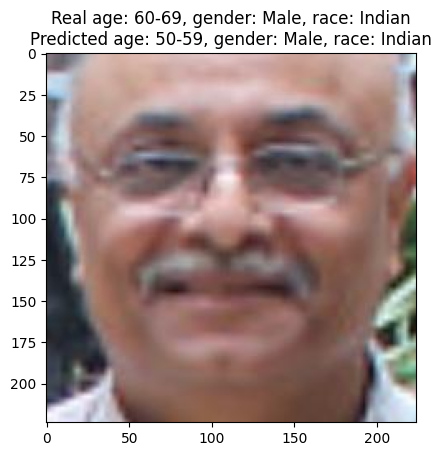

In [10]:
oof_label_df = pd.read_csv(os.path.join(base_path, "fairface_label_val.csv"))
idx = np.random.randint(0,len(oof_label_df))
oof_image_name = oof_label_df.iloc[idx,0]
oof_image_path = os.path.join(base_path, "fairface-img-margin025-trainval", oof_image_name)
oof_image = Image.open(oof_image_path).convert(mode='RGB')

x = test_transforms(oof_image)
age_pred, gender_pred, race_pred = model(x.unsqueeze(0).to('cuda'))

age_pred = age_encoder.inverse_transform(torch.argmax(age_pred).cpu().unsqueeze(0))[0]
gender_pred = gender_encoder.inverse_transform(torch.argmax(gender_pred).cpu().unsqueeze(0))[0]
race_pred = race_encoder.inverse_transform(torch.argmax(race_pred).cpu().unsqueeze(0))[0]

real_age = oof_label_df.iloc[idx, 1]
real_gender = oof_label_df.iloc[idx, 2]
real_race = oof_label_df.iloc[idx, 3]

plt.title(f"Real age: {real_age}, gender: {real_gender}, race: {real_race}\nPredicted age: {age_pred}, gender: {gender_pred}, race: {race_pred}")
plt.imshow(oof_image)